In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython
import pyworld as pw

def play_audio(data, rate):
    IPython.display.display(IPython.display.Audio(data=data,rate=rate))

# Basics of Fourier Transform
---

We fist discuss the basic of fourier transform in discrete space. When we assume the following variables, we can denote the fourier transform as the following.
- $t$: time sequence
- $f(t)$: target signal
- $T$: Period of $f(t)$
    
$$
F(e^{i\frac{2\pi t}{T}}) = \sum^\infty_{n=-\infty} c_n e^{i\frac{2\pi n t}{T}} \\
c_n = \frac1T \int^T_0 f(t) e^{-i\frac{2\pi nt}{T}}dt \\
e^{it}  = \cos(t) + i\sin(t)
$$

- $e^{i\frac{2\pi n t}{T}}$: Sinusoidal basis functions in their complex form
- $c_n$: Fourier coefficients, which determine the amplitude and phase of each sinusoidal component in the series.

References:
- https://www.thefouriertransform.com/series/complexcoefficients.php
---

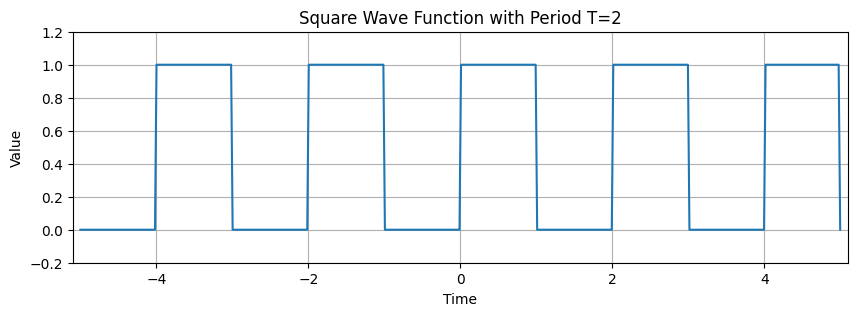

In [2]:
def square_wave(t, T=2):
    return (np.floor(t*(1/T*2)) % 2 == 0).astype(int)

T = 2
nmax = 50 
t = np.linspace(-5, 5, 500)  # Time range from 0 to 10 with 500 points

y = square_wave(t)
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)
plt.plot(t, y)
plt.title(f'Square Wave Function with Period T={T}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-5.1, 5.1)  # Extend y-axis a bit for clearer visualization
plt.ylim(-0.2, 1.2)  # Extend y-axis a bit for clearer visualization
plt.grid()
plt.show()

---

Let me share the calculation flow for fourier transform of the square function. After calculation, we can compute $c_n$ as:
$$
c_0 = \frac12 \\
c_n = \left\{
\begin{aligned}
    0 \hskip3em (n = \pm2, \pm4, ...) \\
    -\frac{i}{\pi n} \hskip3em (n = \pm1, \pm3, ...) \\
\end{aligned}
\right.
$$

Let's implement $c_n$ based on this result and implement square wave function only using sinusoidal waves.

---

In [3]:
def c_square(n):
    if n==0:
        cn = 1/2
    elif n%2==1: # +-1, +=3, ...
        cn = -1j/(np.pi*n)
    elif n%2==0: # +-2, +-4, ...
        cn = 0
    return cn

def e_wave(n, t):
    return np.exp(1j*2*np.pi*n*t/T)

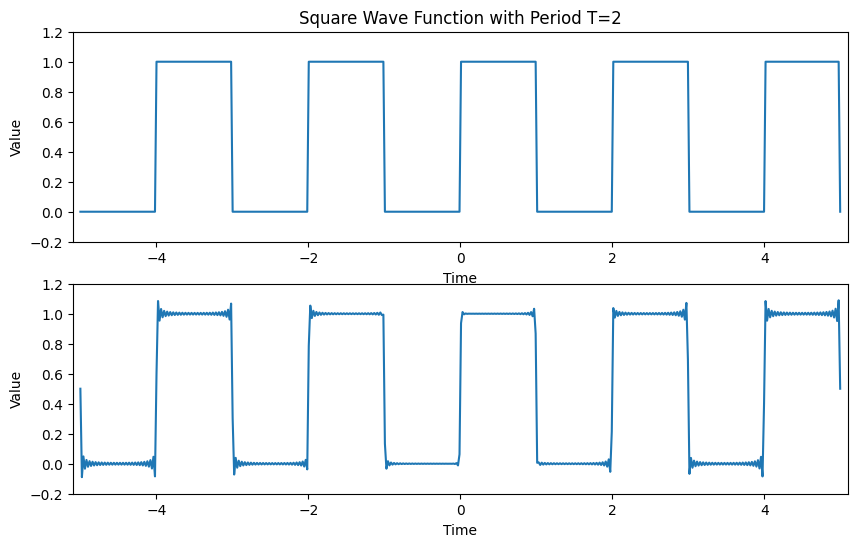

In [4]:
T = 2
nmax = 50 
t = np.linspace(-5, 5, 500)

y = square_wave(t)

pred = c_square(0)*e_wave(0, t)
for n in range(1, nmax+1):
    cn = c_square(n)
    pred += cn * e_wave(n, t) + np.conj(cn) * e_wave(-n, t)
pred = pred.real

fig = plt.figure(figsize=(10, 6))
for i, data in enumerate([y, pred]):
    ax = fig.add_subplot(2, 1, i+1)
    plt.plot(t, data)
    if i==0:
        plt.title(f'Square Wave Function with Period T={T}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xlim(-5.1, 5.1)  
    plt.ylim(-0.2, 1.2)  
plt.show()

---
By calculating Fourier series of the waveform, we can represent the waveform in frequency domain, which is called "spectrum". 

---

(0.0, 0.7)

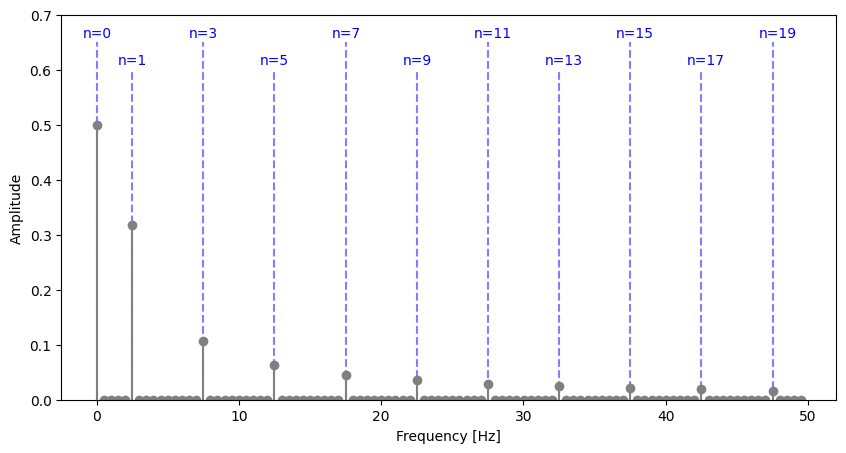

In [5]:
T = 2
sampling_rate = 16000
# sampling_rate = 500
duration = 2

t = np.linspace(0, 10, int(sampling_rate*duration)) 
y = square_wave(t, T)
T = T/(t[-1]/duration)
play_audio(y, sampling_rate)
fft_result = np.fft.fft(y)
magnitude_spectrum = np.abs(fft_result)/len(y)

plt.figure(figsize=(10, 5))
num = 100
M = magnitude_spectrum[:len(magnitude_spectrum)//2]
frequency = np.linspace(0, sampling_rate/2, len(magnitude_spectrum)//2)
n = np.array([0] + list(range(1, 20)[::2]))
for i, n_ in enumerate(n):
    xidx = n_/T
    if i%2==0:
        yidx = 0.65
    else:
        yidx = 0.6
    plt.vlines(xidx, 0, yidx, linestyle="--", color="blue", alpha=0.5)
    plt.text(xidx-1.0, yidx+0.01, f"n={n_}", color="blue")
plt.stem(frequency[:num], M[:num], basefmt=" ", linefmt='gray', markerfmt='o')
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.ylim(0, 0.7)

# Sinewave Composition with different windows
---
In this section, let's check spectrum in more detail. I will combine three sine waves with different frequencies and examine the spectrum of the combined waveform. Here, I will also dicuss the effect of window functions.

References:
- https://download.ni.com/evaluation/pxi/Understanding%20FFTs%20and%20Windowing.pdf
---

Frequency: 300 Hz


Frequency: 1300 Hz


Frequency: 2300 Hz


Combined sine waves


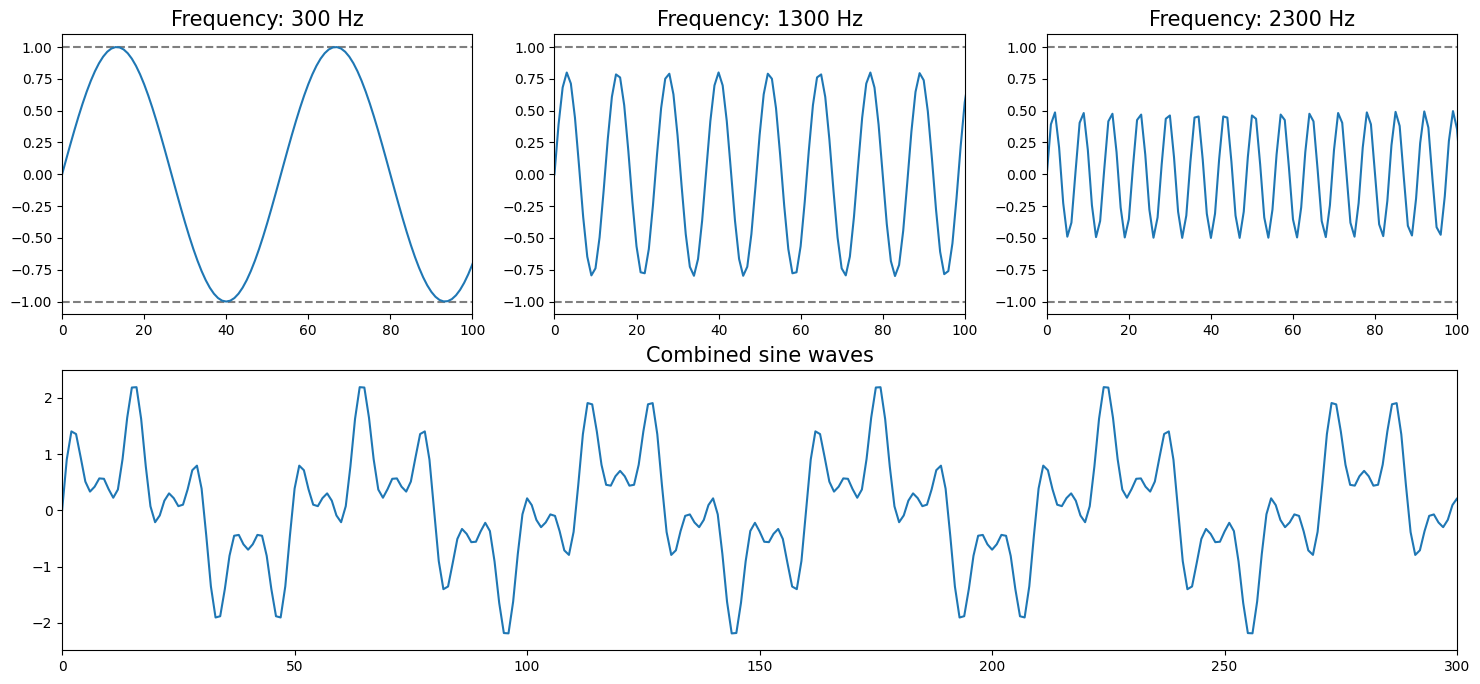

In [6]:
frequencies = [300, 1300, 2300]
ratio = [1.0, 0.8, 0.5]
sr = 16000

def sine_wave(frequency, sampling_rate=16000, duration=2):
    t = np.linspace(0, duration, int(sampling_rate * duration))
    t = 2 * np.pi * frequency * t
    wave = np.sin(t)
    return t, wave

width = 3
length = 2
fig = plt.figure(figsize=(6*width, 4*length))
t, waves = sine_wave(100, sr, duration=5)
waves = np.zeros(waves.shape)
for i, freq in enumerate(frequencies):
    ax = fig.add_subplot(length, width, i+1)
    wave = ratio[i]*sine_wave(freq, sr, duration=5)[1]
    plt.hlines([-1,1], 0, 100, color="black", linestyle="--", alpha=0.5)
    plt.plot(wave)
    plt.ylim(-1.1, 1.1)
    plt.xlim(0, 100)
    title = f"Frequency: {freq} Hz"
    plt.title(title, fontsize=15)
    waves = waves + wave
    print(title)
    play_audio(wave, sr)
ax = fig.add_subplot(length, width, (4,6))
plt.plot(waves)
title = f"Combined sine waves"
plt.title(title, fontsize=15)
print(title)
play_audio(waves, sr)
plt.xlim(0, 300)
plt.show()

---
Let's check the spectrums with different window fucntions. I displayed the spectrums in both linear (magintude) and log (decibels) scales. I will use three window fucntions.
- Rectangular Window
- Hann Window
- Blackman Window

![alt text](img/windows.png "Windows")

---

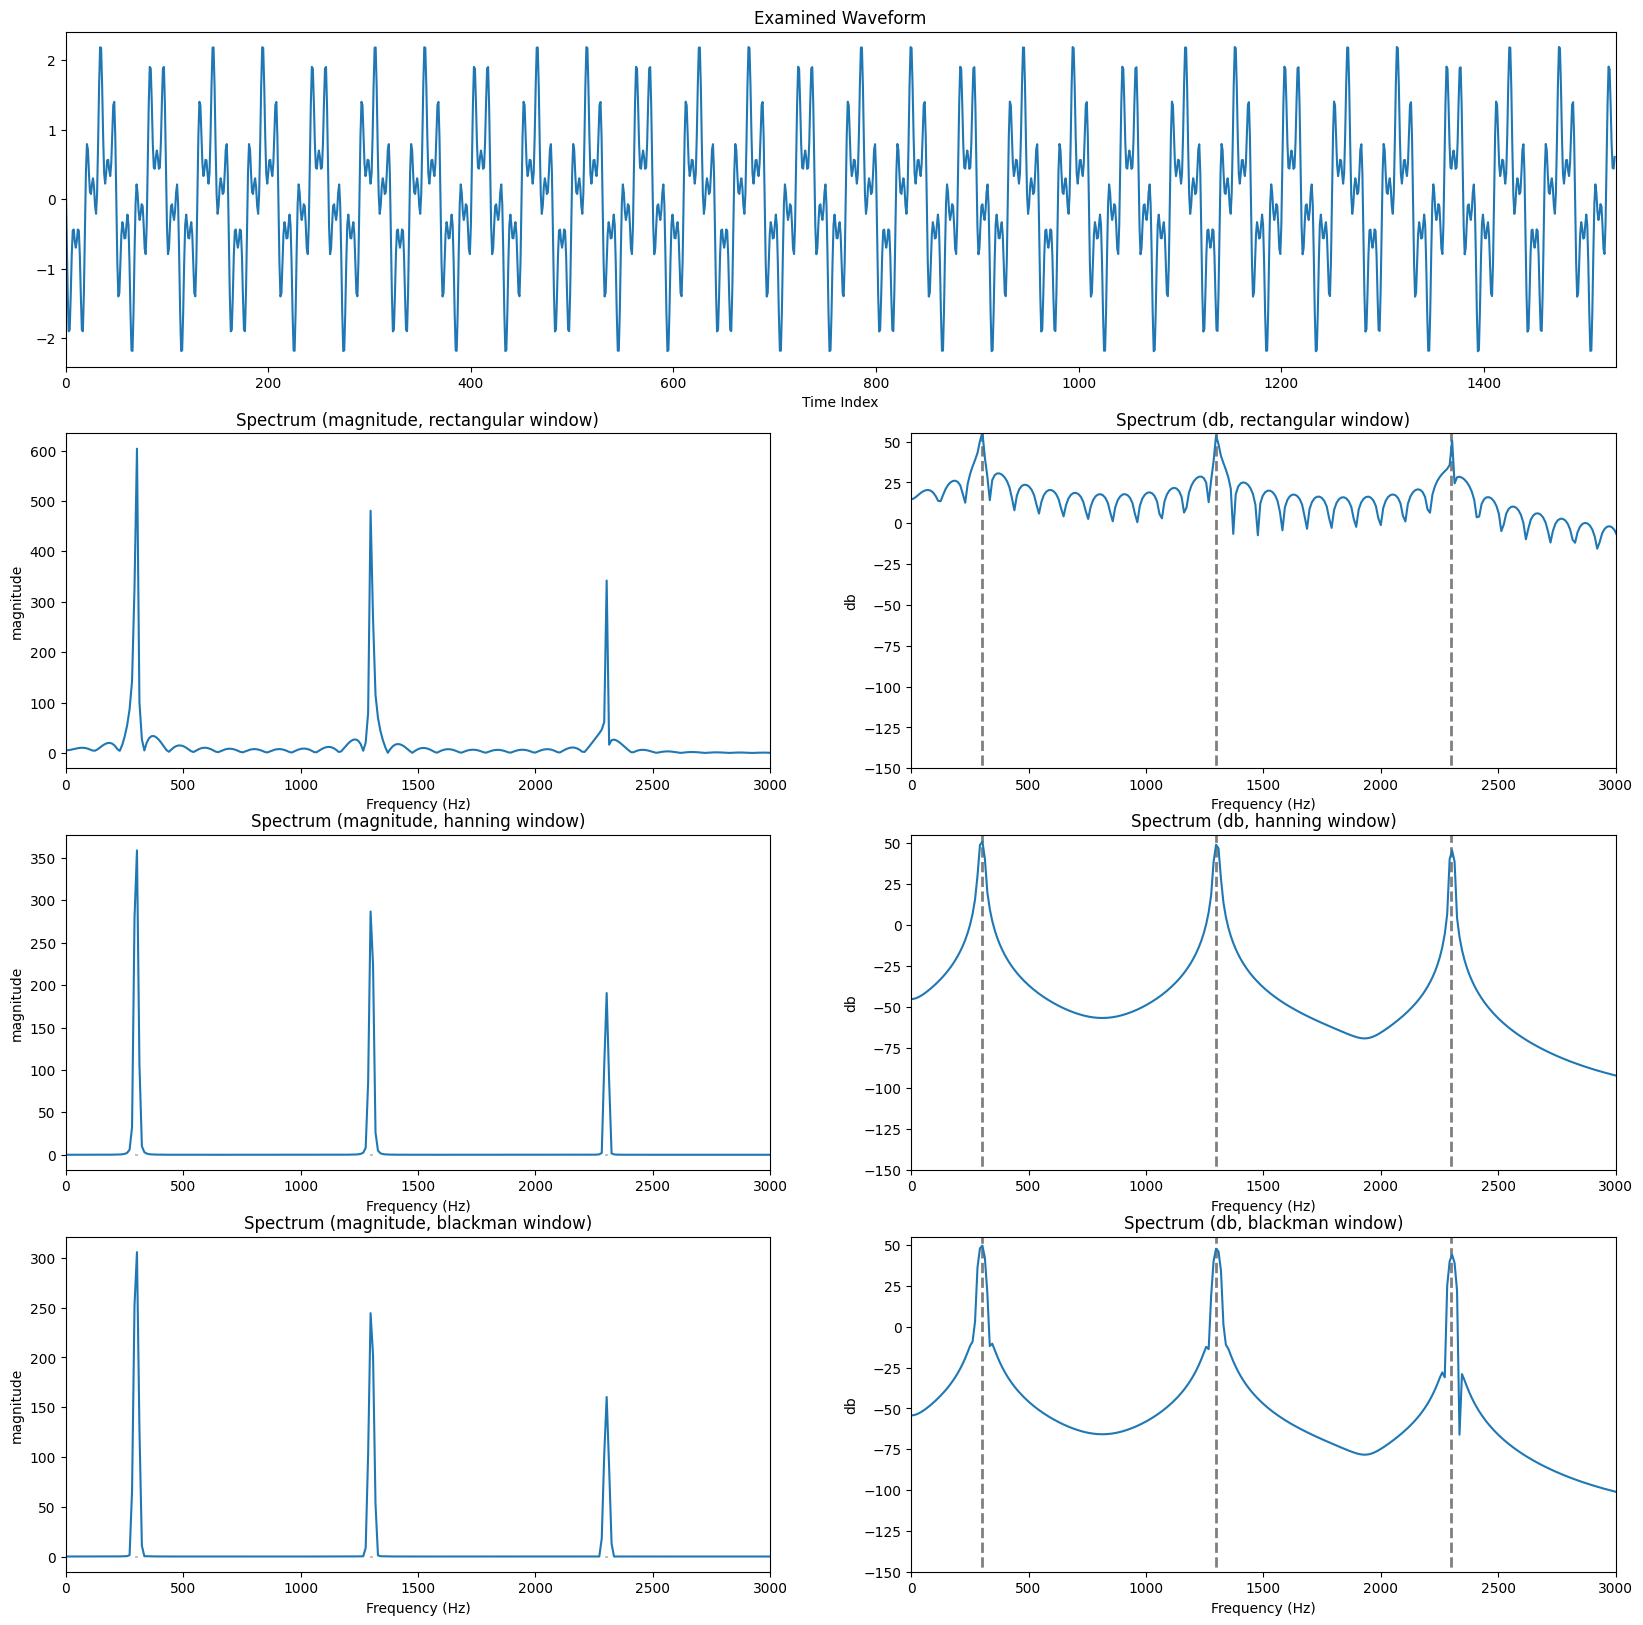

In [7]:
width = 2
length = 4
fig = plt.figure(figsize=(20, 20))
for aw, apply_window in enumerate(["rectangular", "hanning", "blackman"]):
    data = waves[30:sr//10-40]
    if apply_window:
        if apply_window=="blackman":
            windowed_data = data * np.blackman(len(data))
        elif apply_window=="hanning":
            windowed_data = data * np.hanning(len(data))
        elif apply_window=="rectangular":
            a = int(len(data)*0.05)
            b = len(data)-2*a
            window_function = np.concatenate([np.zeros((a)), np.ones((b)), np.zeros((a))])
            windowed_data = data * window_function
    else: 
        windowed_data = data
    fft_result = np.fft.fft(windowed_data)
    magnitude_spectrum = np.abs(fft_result)
    frequency = np.linspace(0, sr/2, len(magnitude_spectrum)//2)

    if aw==0:
        ax = fig.add_subplot(length, width, (1,2))
        plt.xlabel('Time Index')
        plt.title('Examined Waveform')
        plt.plot(data)
        plt.xlim(0, len(data))

    for m, mode in enumerate(["magnitude", "db"]):
        
        if mode=="magnitude":
            data = magnitude_spectrum
        elif mode=="db":
            data = 20*np.log10(magnitude_spectrum)
        ax = fig.add_subplot(length, width, 2*aw+3+m)
        if mode=="magnitude":
            # plt.ylim(-0.1, 1)
            plt.vlines(frequencies, 0, 1, linestyles="--", color="black", linewidth=2, alpha=0.5)
        elif mode=="db":
            plt.ylim(-150, 55)
            plt.vlines(frequencies, -220, 60, linestyles="--", color="black", linewidth=2, alpha=0.5)
        plt.plot(frequency, data[:len(data)//2])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(f'{mode}')
        plt.xlim(0, 3000)
        plt.title(f'Spectrum ({mode}, {apply_window} window)')
plt.show()

---
Also, let's check the spectrograms with different windows.

Spectrogram: An acoustic representation, which is obtained by the Short Time Fourier Transform (STFT). Therefore, it can display the spectrum changes as time goes.

---

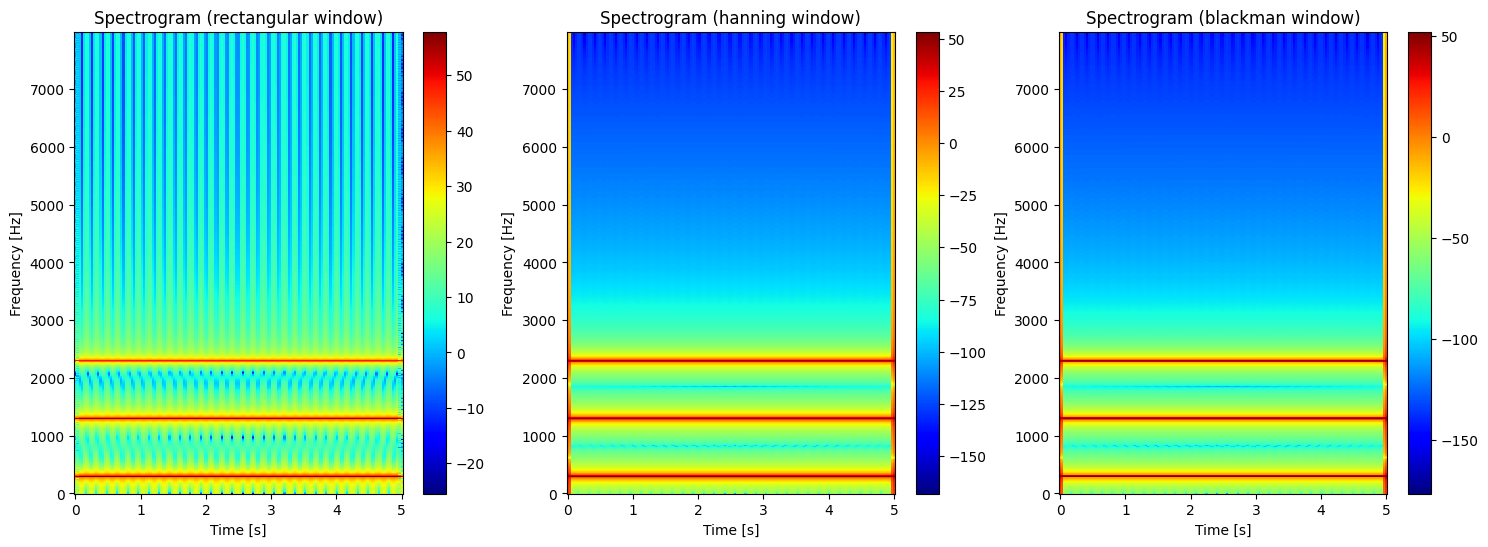

In [8]:
width = 3
length = 1
display_frequency = 8000
fig = plt.figure(figsize=(18, 6))
data = waves[:]
display_freqidx = int(display_frequency/(sr/2)*1024)
for aw, apply_window in enumerate(["rectangular", "hanning", "blackman"]):
    if apply_window=="rectangular":
        wf = np.ones
    elif apply_window=="hanning":
        wf = np.hanning
    elif apply_window=="blackman":
        wf = np.blackman
    spec = librosa.stft(data, window=wf)
    
    M = 20*np.log10(np.abs(spec))
    frequency = np.linspace(0, sr/2, spec.shape[0])
    time = np.linspace(0, len(data)/sr, spec.shape[1])
    
    ax = fig.add_subplot(length, width, aw+1)
    a = ax.pcolormesh(time, frequency[:display_freqidx], M[:display_freqidx, :], cmap = 'jet')
    fig.colorbar(a)
    
    plt.xlabel(f'Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.title(f'Spectrogram ({apply_window} window)')
plt.show()

---
Let's change the vertical axis to mel scale. Mel-scale considers human perception on picth distance. Human is less sensitive to the frequency changes in higher frequencies.

---

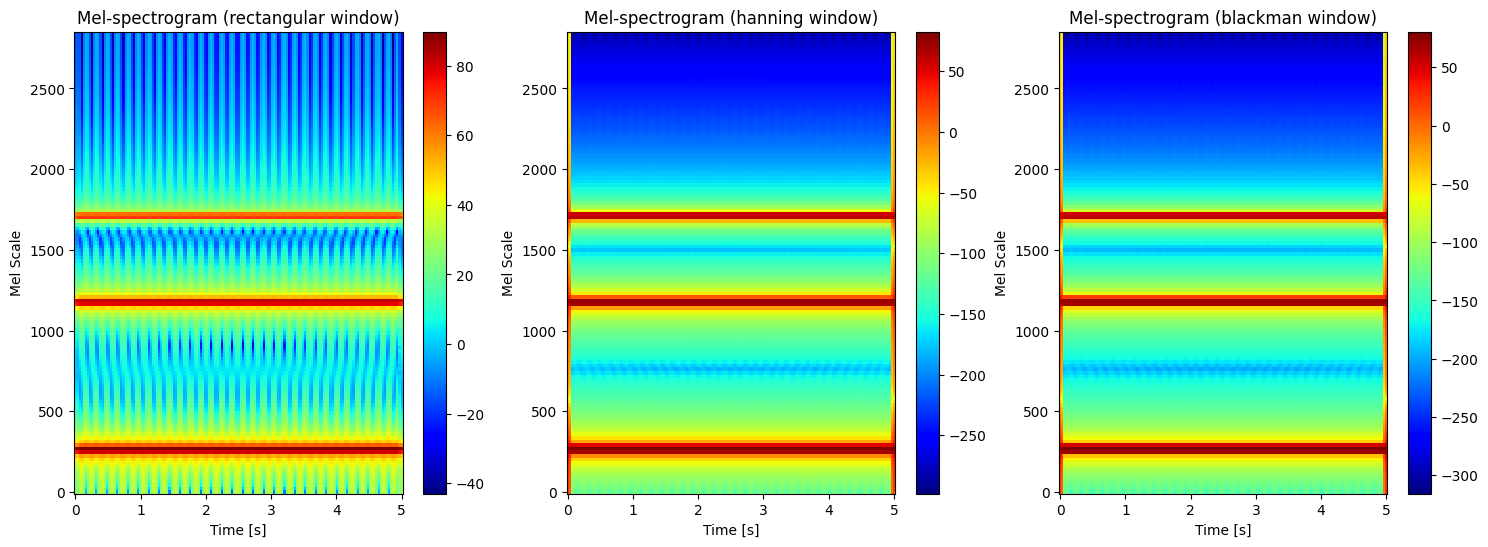

In [9]:
def to_melscale(freq):
    return 2595*np.log10(1+freq/700)

width = 3
length = 1
display_frequency = 8000
fig = plt.figure(figsize=(18, 6))
data = waves[:]
display_freqidx = int(display_frequency/(sr/2)*1024)
for aw, apply_window in enumerate(["rectangular", "hanning", "blackman"]):
    if apply_window=="rectangular":
        wf = np.ones
    elif apply_window=="hanning":
        wf = np.hanning
    elif apply_window=="blackman":
        wf = np.blackman
    mel = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000, window=wf)
    
    M = 20*np.log10(np.abs(mel))
    # frequency = 
    # melscale = 2595*np.log10(1+frequency/700)
    melscale = np.linspace(0, to_melscale(sr/2), mel.shape[0])
    time = np.linspace(0, len(data)/sr, mel.shape[1])
    
    ax = fig.add_subplot(length, width, aw+1)
    a = ax.pcolormesh(time, melscale[:display_freqidx], M[:display_freqidx, :], cmap = 'jet')
    fig.colorbar(a)
    
    plt.xlabel(f'Time [s]')
    plt.ylabel('Mel Scale')
    plt.title(f'Mel-spectrogram ({apply_window} window)')
plt.show()

# Convolution 
---
In this section, I will introduce convolution operation and its relation to this topic. Convolution is a mathematical way of combining two signals to form a third signal and defined as follows:

$$
Y(k) = \sum^{L-1}_{m=0} W(m) X (k-m)
$$
Where:
- $W$: The first signal with length $L$.
    - window
- $X$: Another signal with longer length than $L$.
    - original signal
- $Y(k)$:$k$-th index of convolved signal
    - Y is the convolved signal


---

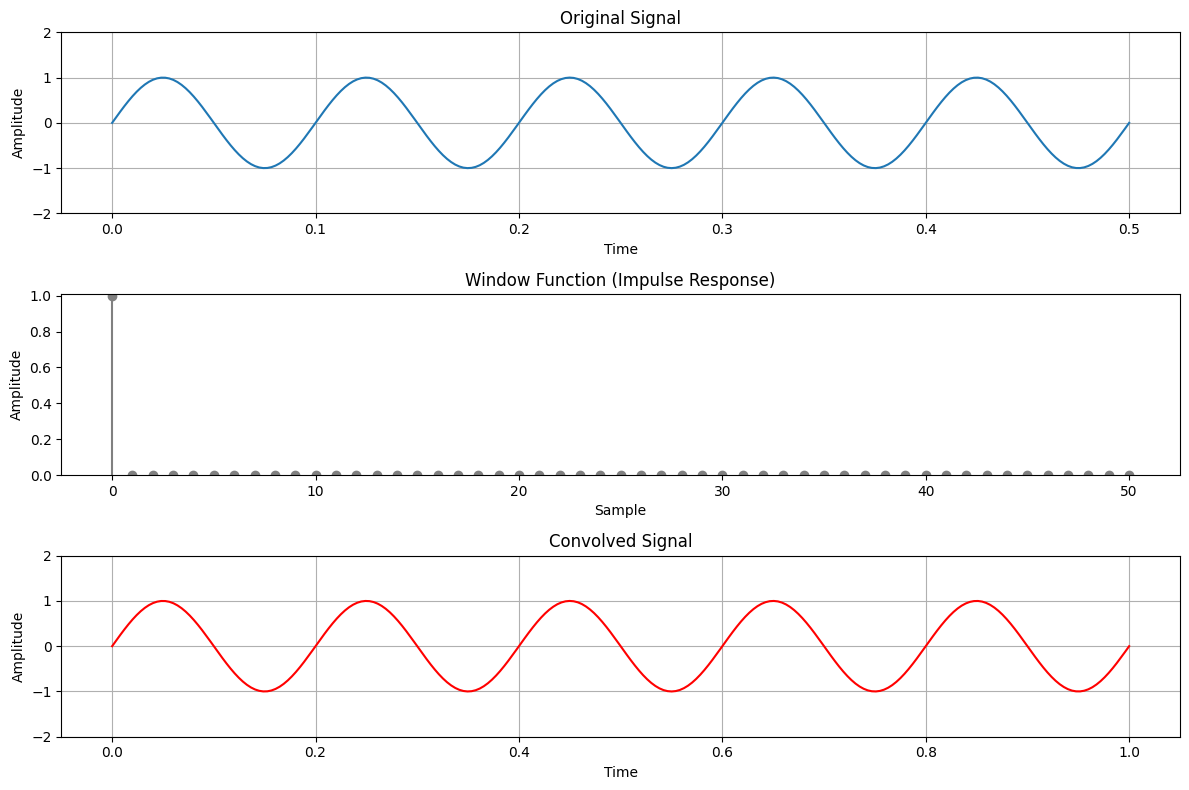

In [10]:
impulses = [
    [0, 1], # no phase change
    # [15, 1],
    # [25, 1], # π phase change
]


def convolve_signals(x, h):
    return np.convolve(x, h, mode='full')

T = 0.5
fs = 500
t = np.linspace(0, T, int(fs*T))
frequency = 5
windowsize = 51
x = np.sin(2 * np.pi * frequency * t / T)

h = np.array([0.0]*windowsize)
for imp in impulses:
    h[imp[0]] = imp[1]

y = convolve_signals(x, h)[:len(x)]
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.title("Original Signal")
plt.plot(t, x, label='Original Signal')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.ylim(-2.0, 2.0)
plt.grid()

plt.subplot(3, 1, 2)
plt.title("Window Function (Impulse Response)")
plt.stem(np.arange(len(h)), h, basefmt=" ", linefmt='gray', markerfmt='o')
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.ylim(0, max(h) + 0.01)

plt.subplot(3, 1, 3)
plt.title("Convolved Signal")
t_extended = np.linspace(0, 1, len(y))  # Adjusting the time axis for the convolution output
plt.plot(t_extended, y, color='r', label='Convolved Signal')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.ylim(-2.0, 2.0)
plt.grid()

plt.tight_layout()
plt.show()


---
Why convolution is important: It's because, thanks to [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem). We can claim the followings.
- Convolution in time domain is equivalent to Multiplication in frequency domain
- Multiplication in time domain is equivalent to Convolution in frequency domain

And, thanks the second one, we can consider that applying window (multiplication) in time domain is the convolution between the fourier transforms of the signal and the window fucntions.
    
References:
- https://www.youtube.com/watch?v=Ex318cCXSBM

---

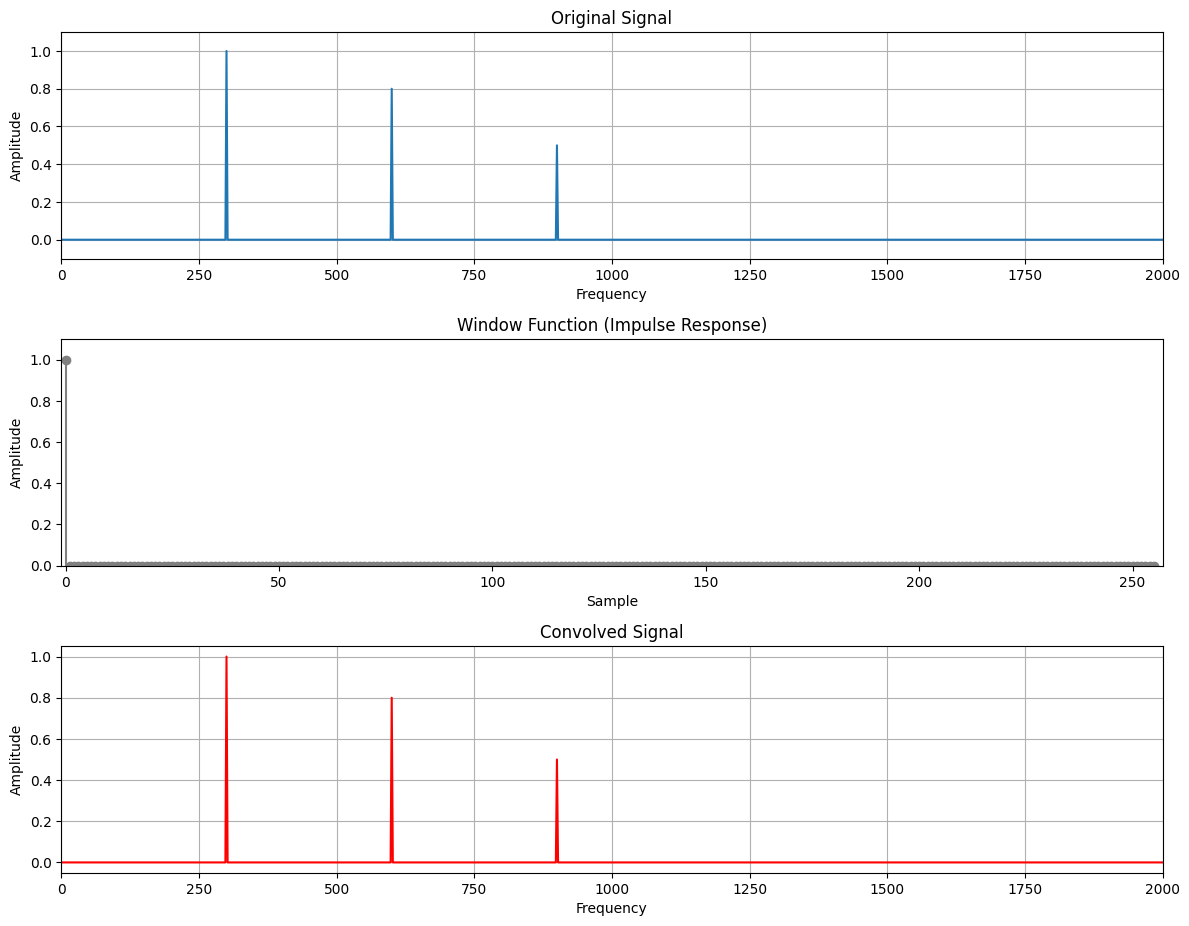

In [31]:
frequencies = [300, 600, 900]
ratio = [1.0, 0.8, 0.5]
fs = 4000
windowsize = 256
impulses = [
    [0, 1], # no phase change
    # [2, 0.8],
    # [50, 1], # π phase change
]

waves = np.ones(sine_wave(100, fs)[1].shape)*1e-8
for i, freq in enumerate(frequencies):
    wave = ratio[i]*sine_wave(freq, fs)[1]
    waves = waves + wave
data = waves
fft_result = np.fft.fft(data)
magnitude_spectrum = 20*np.log10(np.abs(fft_result)/(len(data)/2))
frequency = np.linspace(0, sr/2, len(magnitude_spectrum)//2)

x = np.ones(frequency.shape)*1e-8
for f, freq in enumerate(frequencies):
    freqidx = np.argmin(np.abs(frequency-freq))
    x[freqidx] = ratio[f]

h = np.array([0.0]*windowsize)
for imp in impulses:
    h[imp[0]] = imp[1]
    
y = convolve_signals(x, h)[:len(x)]
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.title("Original Signal")
plt.plot(frequency, x, label='Original Signal')
# plt.plot(frequency, 20*np.log10(x), label='Original Signal')
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.xlim(0, 2000)
plt.ylim(-0.1, 1.1)
plt.grid()

plt.subplot(4, 1, 2)
plt.title("Window Function (Impulse Response)")
plt.stem(np.arange(len(h)), h, basefmt=" ", linefmt='gray', markerfmt='o')
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.xlim(-1, len(h)+1)
plt.ylim(0, max(h) + 0.1)

plt.subplot(4, 1, 3)
plt.title("Convolved Signal")
t_extended = np.linspace(0, 1, len(y))  # Adjusting the time axis for the convolution output
plt.plot(frequency, y, color='r', label='Convolved Signal')
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.xlim(0, 2000)
# plt.ylim(-2.0, 2.0)
plt.grid()

plt.tight_layout()
plt.show()

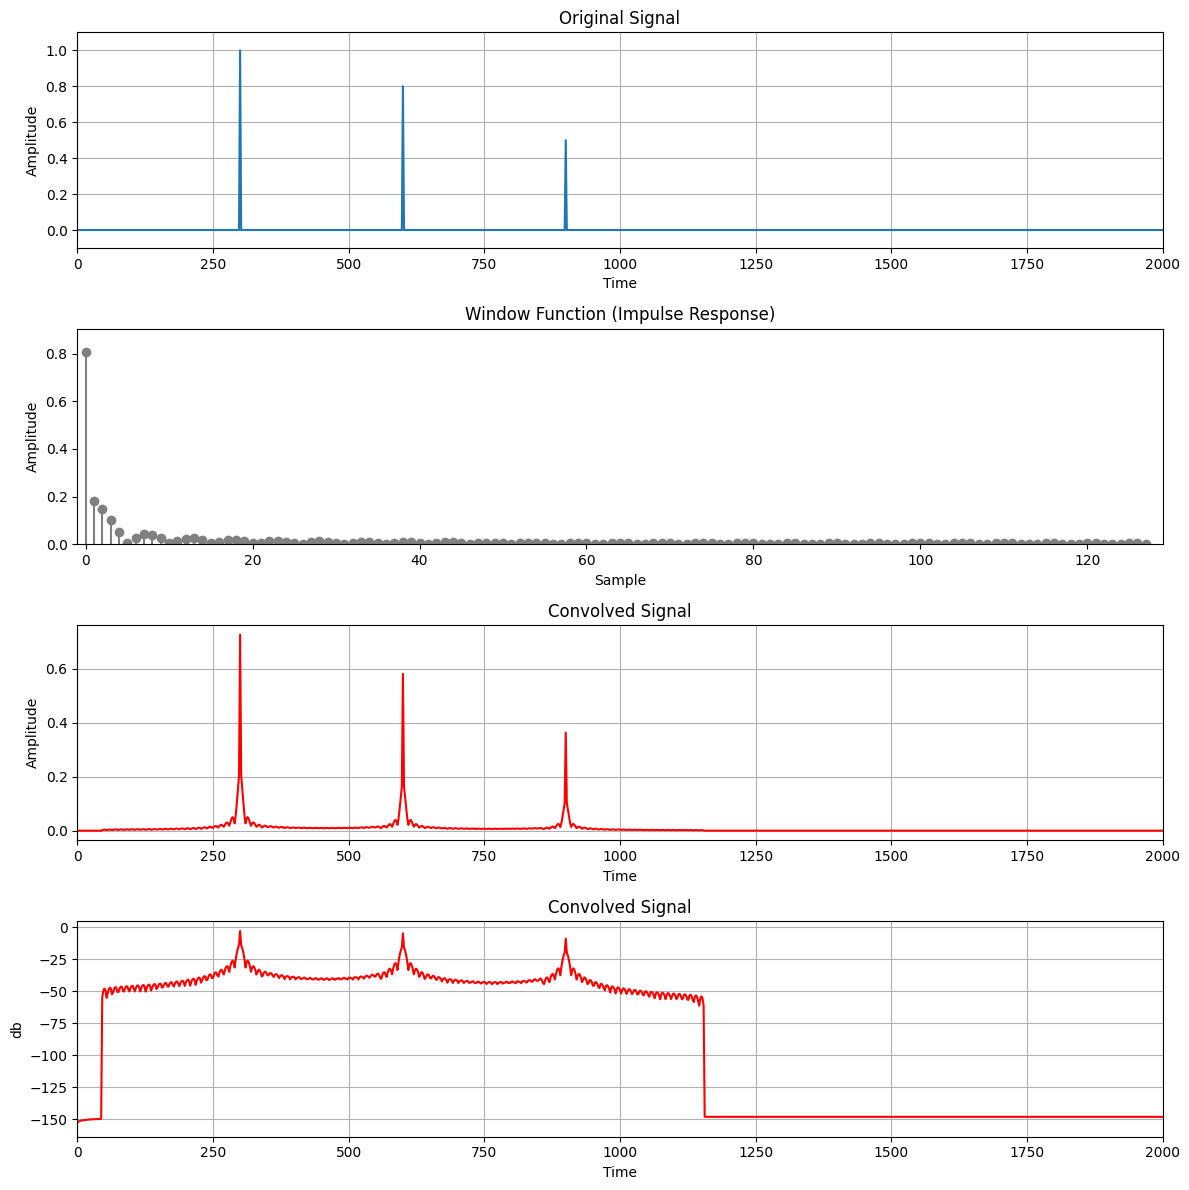

In [33]:
frequencies = [300, 600, 900]
ratio = [1.0, 0.8, 0.5]
fs = 4000
window_name = "rectangular"
windowsize = 256

waves = np.ones(sine_wave(100, fs)[1].shape)*1e-8
for i, freq in enumerate(frequencies):
    wave = ratio[i]*sine_wave(freq, fs)[1]
    waves = waves + wave
data = waves
fft_result = np.fft.fft(data)
magnitude_spectrum = 20*np.log10(np.abs(fft_result)/(len(data)/2))
frequency = np.linspace(0, sr/2, len(magnitude_spectrum)//2)

x = np.ones(frequency.shape)*1e-8
for f, freq in enumerate(frequencies):
    freqidx = np.argmin(np.abs(frequency-freq))
    x[freqidx] = ratio[f]
if window_name == "rectangular":
    a = int(windowsize*0.1)
    b = windowsize-2*a
    window_function = np.concatenate([np.zeros((a)), np.ones((b)), np.zeros((a))])
elif window_name == "hamming":
    window_function = np.hamming(windowsize)
elif window_name == "hanning":
    window_function = np.hanning(windowsize)
elif window_name == "blackman":
    window_function = np.blackman(windowsize)

window_fft = np.fft.fft(window_function)
window_magnitude = np.abs(window_fft) / (windowsize)
# window_magnitude = np.abs(window_fft)
# window_magnitude = 20*np.log(window_magnitude + 1e-10)
h = window_magnitude[:windowsize//2]
y = convolve_signals(x, h)[:len(x)]
y = convolve_signals(y[::-1], h)[:len(x)][::-1]
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.title("Original Signal")
plt.plot(frequency, x, label='Original Signal')
# plt.plot(frequency, 20*np.log10(x), label='Original Signal')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim(0, 2000)
plt.ylim(-0.1, 1.1)
plt.grid()

plt.subplot(4, 1, 2)
plt.title("Window Function (Impulse Response)")
plt.stem(np.arange(len(h)), h, basefmt=" ", linefmt='gray', markerfmt='o')
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.xlim(-1, len(h)+1)
plt.ylim(0, max(h) + 0.1)

plt.subplot(4, 1, 3)
plt.title("Convolved Signal")
t_extended = np.linspace(0, 1, len(y))  # Adjusting the time axis for the convolution output
plt.plot(frequency, y, color='r', label='Convolved Signal')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim(0, 2000)
# plt.ylim(-2.0, 2.0)
plt.grid()

plt.subplot(4, 1, 4)
plt.title("Convolved Signal")
t_extended = np.linspace(0, 1, len(y))  # Adjusting the time axis for the convolution output
plt.plot(frequency, 20*np.log10(y), color='r', label='Convolved Signal')
plt.xlabel("Time")
plt.ylabel("db")
plt.xlim(0, 2000)
# plt.ylim(-100, 0)
plt.grid()

plt.tight_layout()
plt.show()

# Source Filter Theory (Model)
---
The source-filter model in speech synthesis decouples the speech production process into source (vibrations at the vocal folds) and filter (the shape and the configuration of the vocal tract). In this section, I will extract the filter from the given speech sample and apply another source to synthesize a new speech.

References:
- https://splab.net/apd/g500/

---

In [36]:
def generate_pulse_sequence(duration, sr, f0=100, get_t=False):
    t = np.arange(int(duration * sr)) / sr
    a = np.arange(0, duration, 1/f0).reshape(1, -1)
    pulses = np.zeros(t.shape)
    pulses[np.abs(t.reshape(-1, 1)-a).argmin(0)] = 1.0
    if get_t:
        return t, pulses
    else:
        return pulses

sr = 16000
y, _ = librosa.load("audio/sho-a.wav", sr=sr)
shof0, sp, ap = pw.wav2world(y.astype(np.float), sr)
shof0 = np.mean(shof0[shof0>0])

---
Let's first check the pulse sequence (source). Fundamental frequency (f0) represents the pitch of the speech.

---

Text(0.5, 1.0, 'Pulse Sequence')

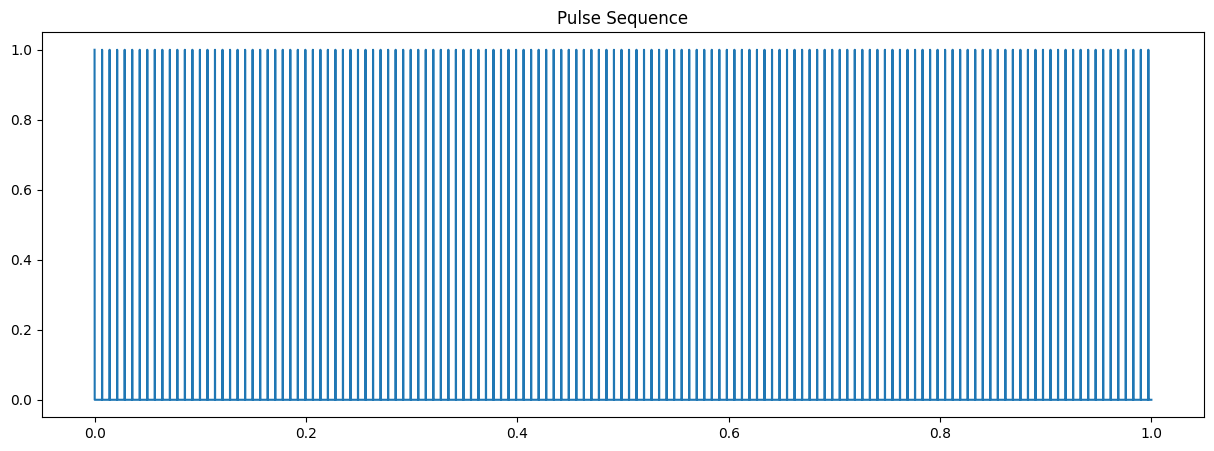

In [37]:
t, pulses = generate_pulse_sequence(1.0, sr, f0=shof0, get_t=True)
play_audio(pulses, sr)

plt.figure(figsize=(15, 5))
plt.plot(t, pulses)
plt.title("Pulse Sequence")

---
Next, we will get "filter". 
We will use the sample audio of "/a/e/i/o/u" to obtain the vocal tract filter. 
To get the filter from the spectrum, we can follow the following step.
1. Get Cepstrum
2. Remove the higher quefrency parts
3. Get spectrum/waveform of the filter
4. Combine it with "source".

Let's do it together.
We can get the cepstrum by the steps in the lecture slide.

---

Text(0.5, 1.0, 'Cepstrum')

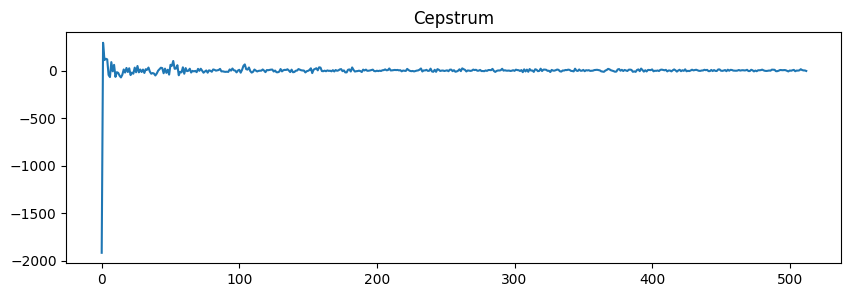

In [38]:
audio_path = "audio/sho-u.wav"
y, sr = librosa.load(audio_path, sr=None)  # Load audio at its original sampling rate
play_audio(y, sr)

# Obtain the cepstrum by following the steps in the lecture slide
spec = librosa.stft(y) # Apply windows and time-frequency transform
mag = np.abs(spec) # Get the absolute values
log_mag = np.log(mag + 1e-8) # Change to log scale
cepstrum = np.fft.rfft(log_mag, axis=0) # Apply another time-frequency transform

plt.figure(figsize=(10,3))
plt.plot(cepstrum[:,-1])
plt.title("Cepstrum")

---
Remove the higher quefrency parts

---

Text(0.5, 1.0, 'Cepstrum (Only Lower Quefrency)')

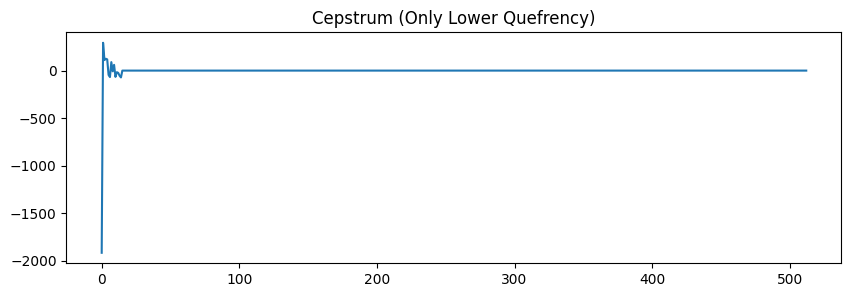

In [39]:
lowpass_num = 15
# Delete the higher frequencies of cepstrum to get the envelope of spectrum.
lp_cepstrum = cepstrum.copy()
lp_cepstrum[lowpass_num:] = 0

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1, 1, 1)
plt.plot(lp_cepstrum[:,-1])
plt.title("Cepstrum (Only Lower Quefrency)")

---
Get Waveform of the filter

---

Text(0.5, 1.0, 'Log-magnitude of Spectrum (Filter)')

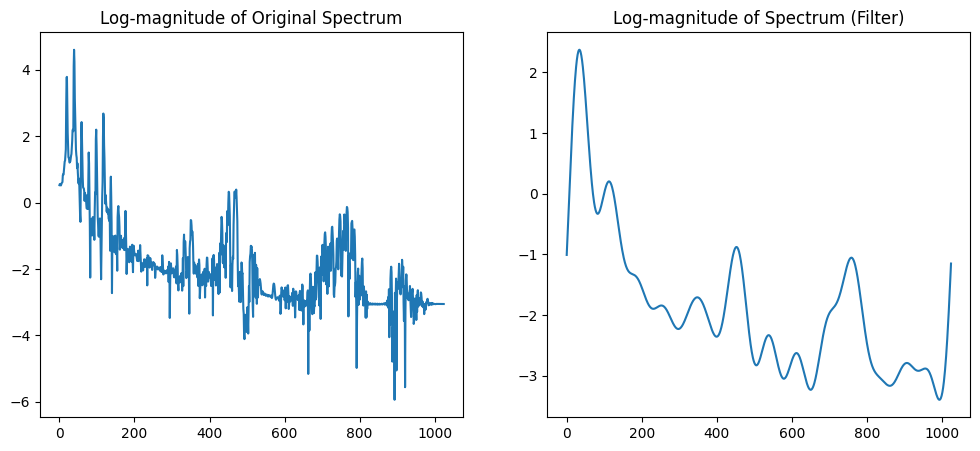

In [40]:
# Reverse the steps to obtain the envelope of spectrum in time domain
log_mag_back = np.fft.irfft(lp_cepstrum, n=1025, axis=0) # Convert back to log-magnitude space
mag_back = np.exp(log_mag_back)
spec_back = mag_back * np.exp(1j * np.angle(spec))
y_back = librosa.istft(spec_back)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(log_mag[:,-1])
plt.title("Log-magnitude of Original Spectrum")
ax = fig.add_subplot(1, 2, 2)
plt.plot(log_mag_back[:,-1])
plt.title("Log-magnitude of Spectrum (Filter)")

Original


Pulses


Reconstructed


Text(0.5, 1.0, 'Log-magnitude of Spectrum (Reconstructed)')

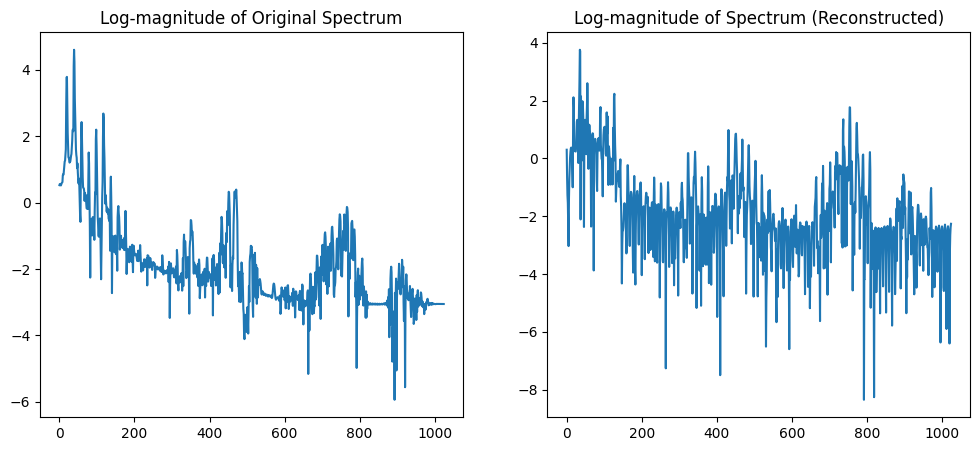

In [41]:
wav_time = np.convolve(pulses, y_back, mode="same")

print("Original")
play_audio(y, sr)
print("Pulses")
play_audio(pulses, sr)
print("Reconstructed")
play_audio(wav_time, sr)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(log_mag[:,-1])
plt.title("Log-magnitude of Original Spectrum")
ax = fig.add_subplot(1, 2, 2)
plt.plot(np.log(np.abs(librosa.stft(wav_time).real))[:,-1])
plt.title("Log-magnitude of Spectrum (Reconstructed)")

---
Let's combine all steps and apply to other speech samples.


---

Source Pulses: f0 is 140.41148160724617 Hz


-------------------------------------------
/a/


--- Combined in Time Domain


--- Combined in Frequency Domain


-------------------------------------------
/e/


--- Combined in Time Domain


--- Combined in Frequency Domain


-------------------------------------------
/i/


--- Combined in Time Domain


--- Combined in Frequency Domain


-------------------------------------------
/o/


--- Combined in Time Domain


--- Combined in Frequency Domain


-------------------------------------------
/u/


--- Combined in Time Domain


--- Combined in Frequency Domain


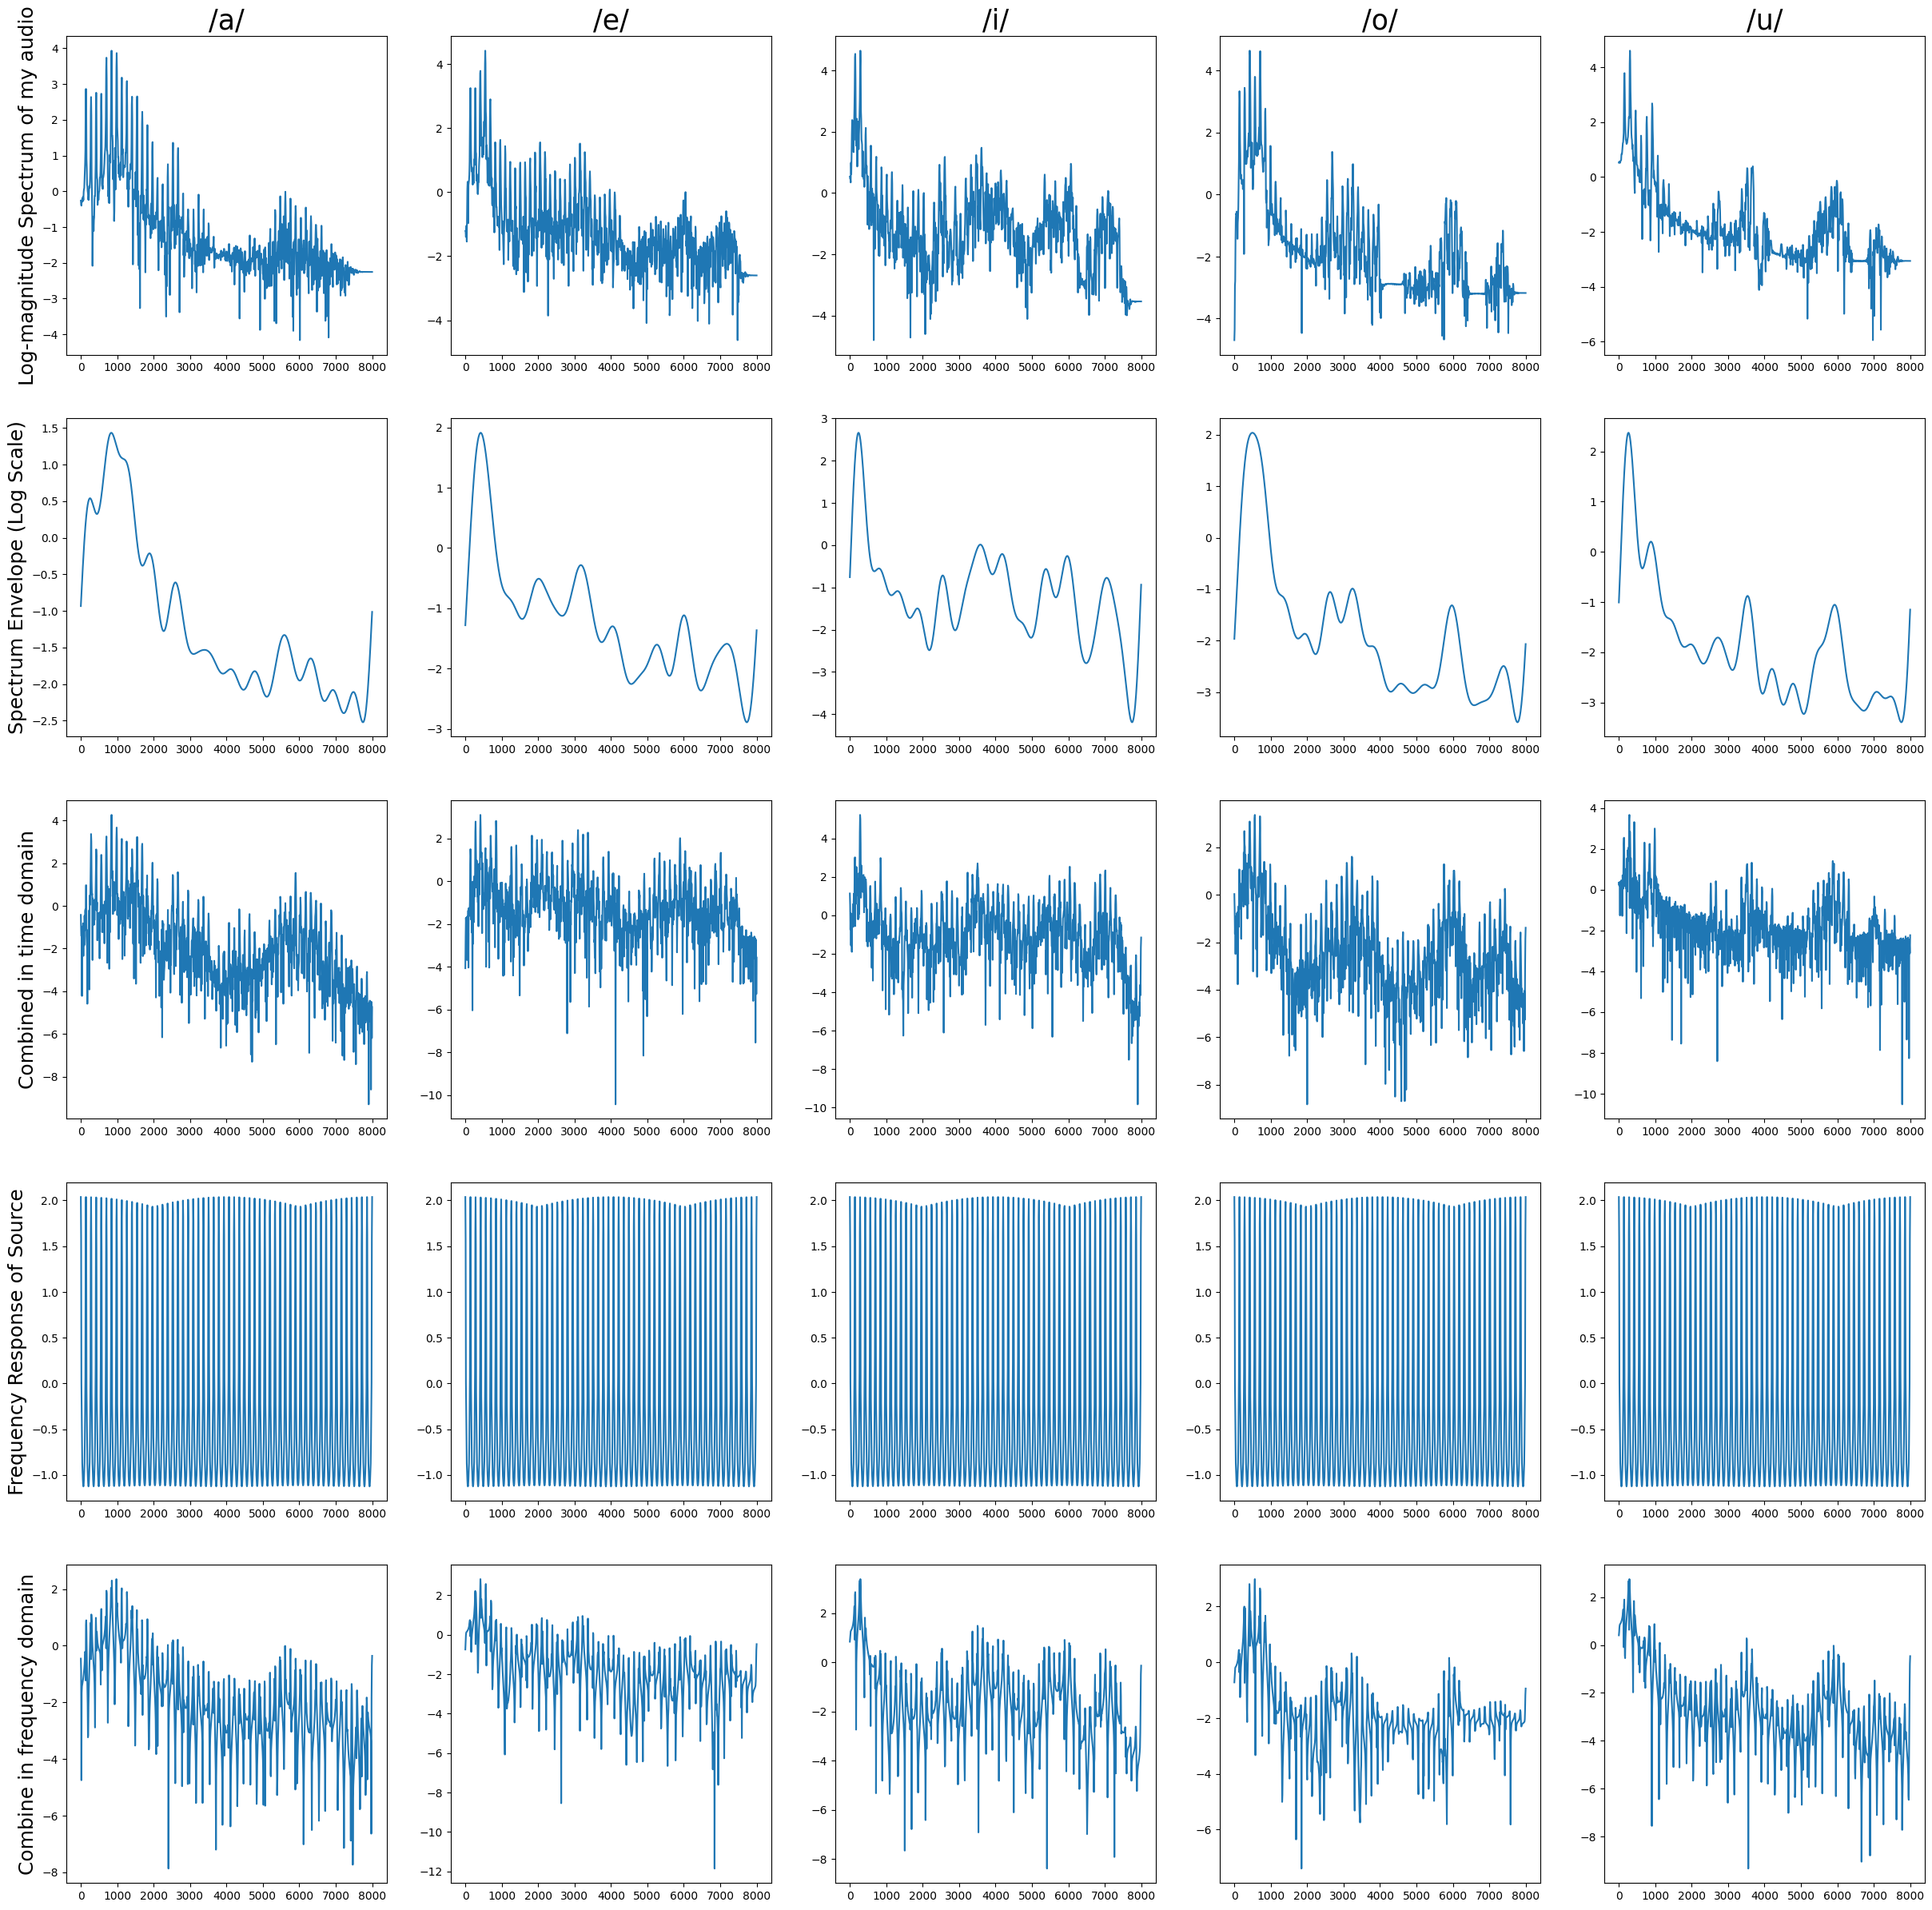

In [56]:
lowpass_num = 15
f0 = shof0 # fundamental frequency of the source
# f0 = 300

pulses = generate_pulse_sequence(0.6, sr, f0)
print(f"Source Pulses: f0 is {f0} Hz")
play_audio(pulses, sr)
labels = [
    "Log-magnitude Spectrum of my audio",
    "Spectrum Envelope (Log Scale)",
    "Combined in time domain",
    "Frequency Response of Source",
    "Combine in frequency domain",
         ]
paths = [
    "audio/sho-a.wav", 
    "audio/sho-e.wav", 
    "audio/sho-i.wav", 
    "audio/sho-o.wav", 
    "audio/sho-u.wav", 
]
length = len(labels)
width = len(paths)
fig = plt.figure(figsize=(6*width,6*length))
for p, audio_path in enumerate(paths):
    pronunciation = "/"+audio_path.split("-")[-1][:1]+"/"
    y, _ = librosa.load(audio_path, sr=sr)  # Load audio at its original sampling rate
    print("-------------------------------------------")
    print(pronunciation)
    play_audio(y, sr)

    # Obtain the cepstrum by following the steps in the lecture slide
    spec = librosa.stft(y) # Apply windows and time-frequency transform
    mag = np.abs(spec) # Get the absolute values
    log_mag = np.log(mag + 1e-8) # Change to log scale
    cepstrum = np.fft.rfft(log_mag, axis=0) # Apply another time-frequency transform

    # Delete the higher frequencies of cepstrum to get the envelope of spectrum.
    lp_cepstrum = cepstrum.copy()
    lp_cepstrum[lowpass_num:] = 0
    log_mag_back = np.fft.irfft(lp_cepstrum, n=1025, axis=0) # Convert back to log-magnitude space

    # Reverse the steps to obtain the envelope of spectrum in time domain
    mag_back = np.exp(log_mag_back)
    # spec_back = mag_back + 0j
    spec_back = mag_back * np.exp(1j * np.angle(spec))
    y_back = librosa.istft(spec_back)
    
    # Combine the source (pulse sequence) and the filter (envelope) in time domain by convolution operation
    wav_time = np.convolve(pulses, y_back, mode="same")
    print("--- Combined in Time Domain")
    play_audio(wav_time, sr)
    
    ## Get spectrogram of the pulses
    spec_pulses = librosa.stft(pulses) 
    mag_pulses = np.abs(spec_pulses)
    log_mag_pulses = np.log(mag_pulses + 1e-8)
    
    # Combine the source (pulse sequence) and the filter (envelope) in frequency domain by multiplication
    mag_combined = mag_back*mag_pulses
    log_mag_combined = np.log(mag_combined + 1e-8)
    spec_combined = mag_combined * np.exp(1j * np.angle(spec_pulses))
    wav_freq = librosa.istft(spec_combined)
    print("--- Combined in Frequency Domain")
    play_audio(wav_freq, sr)

    M_list = [
        log_mag[:, -1],
        log_mag_back[:,-1],
        np.log(np.abs(librosa.stft(wav_time).real))[:,-1],
        log_mag_pulses[:,-1],
        np.log(np.abs(librosa.stft(wav_freq).real))[:,-1],
    ]
    for i, M in enumerate(M_list):
        fig.add_subplot(length, width, width*i+p+1)
        frequency = np.linspace(0, sr//2, M.shape[0])
        plt.plot(frequency, M)
        if i==0:
            plt.title(pronunciation, fontsize=25)
        if p==0:
            plt.ylabel(labels[i], fontsize=18)

# Appendix 1: Frequency Response (Fourier Transform) of Window Functions

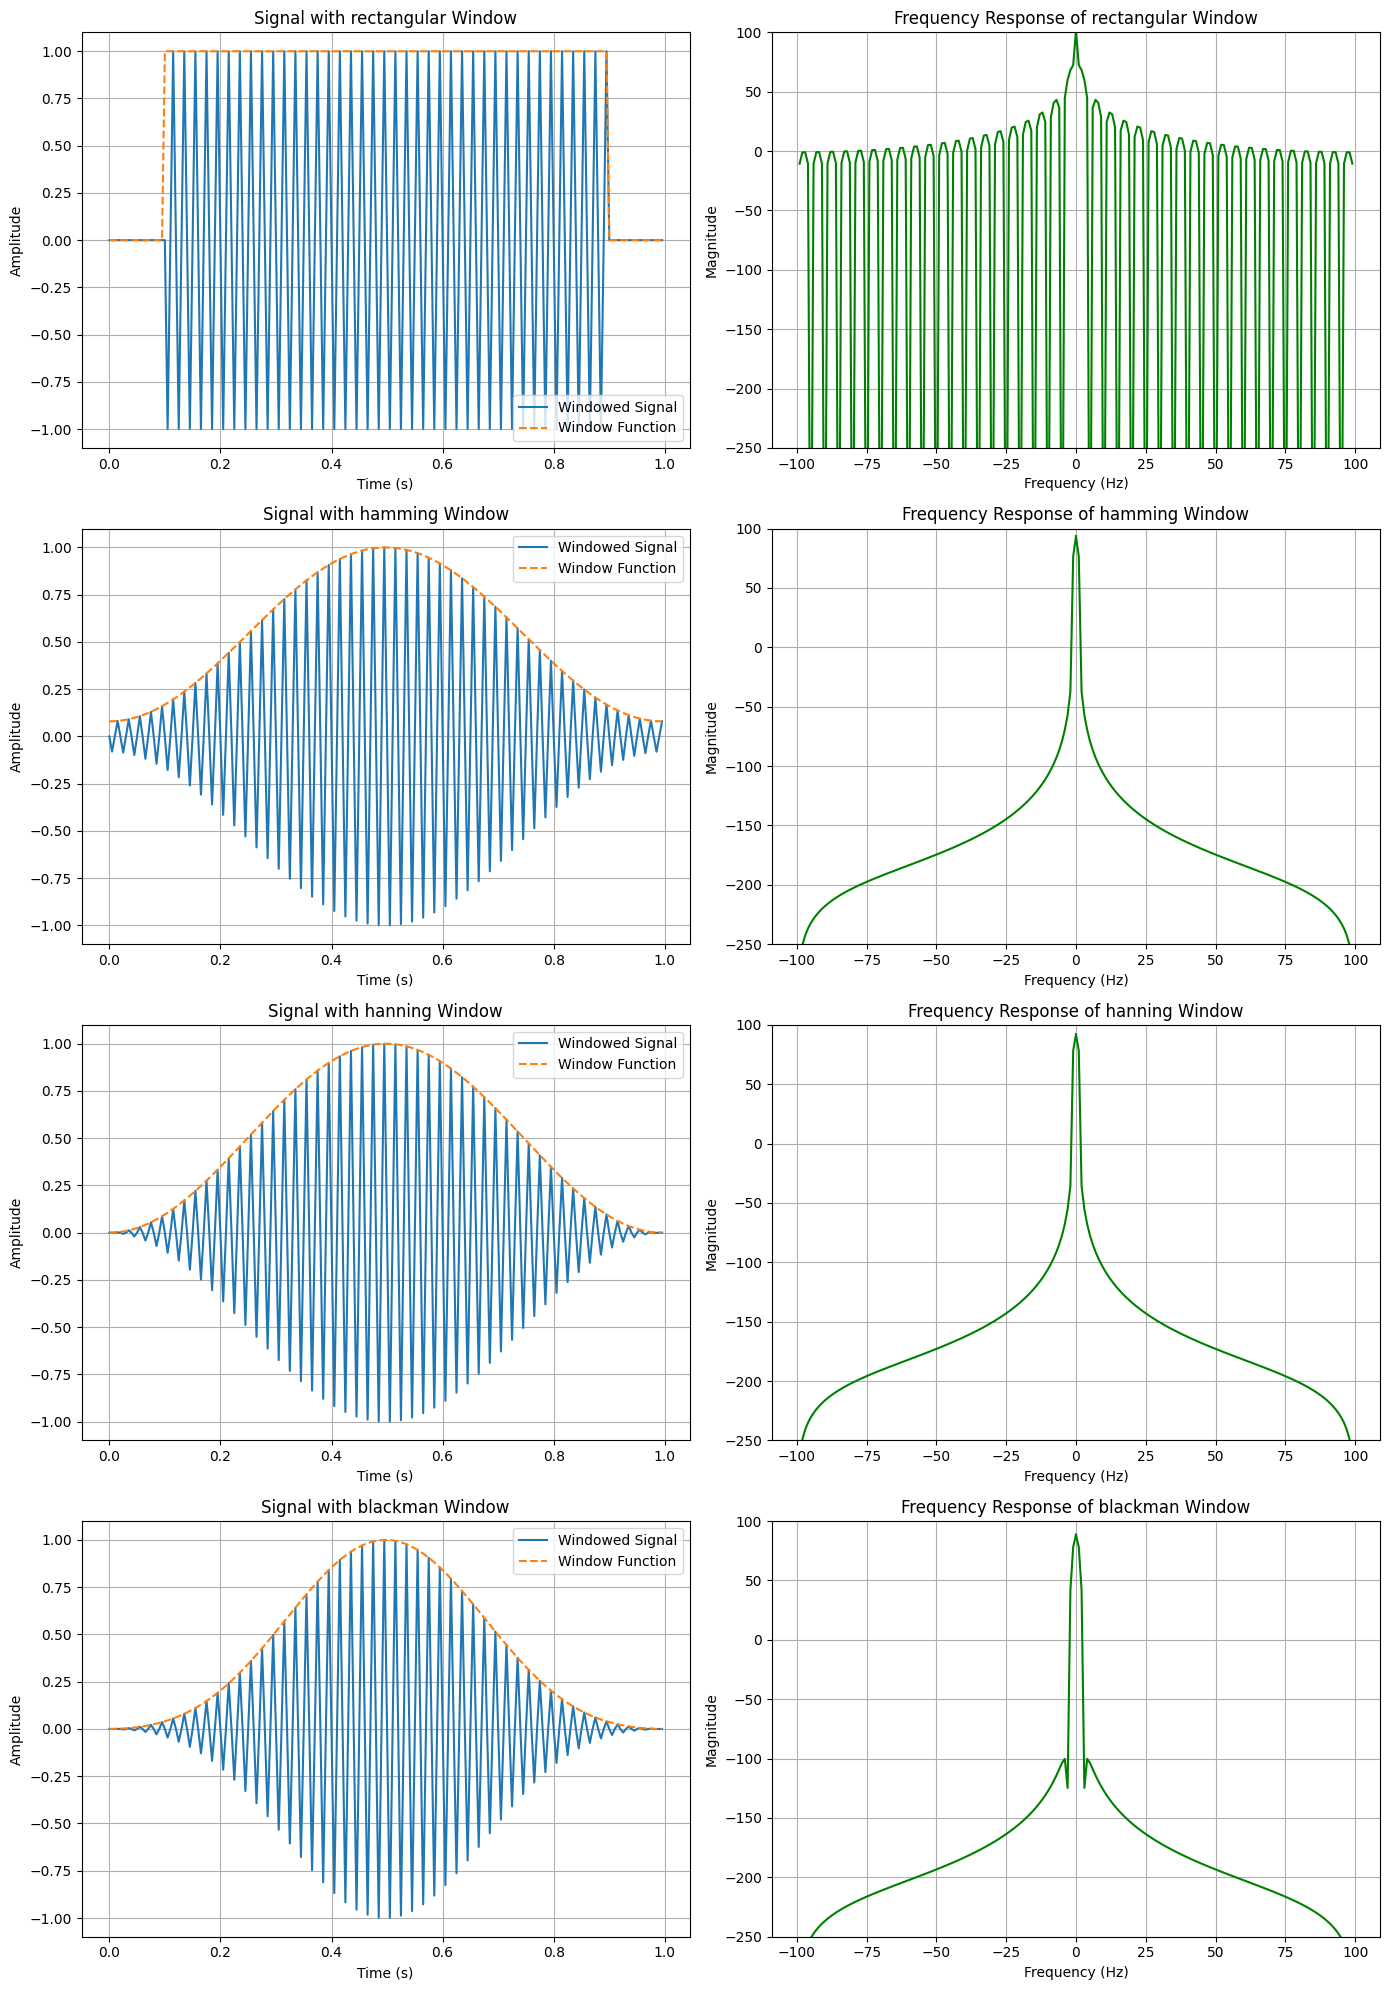

In [57]:
import numpy as np
import matplotlib.pyplot as plt

fs = 200  # Sampling frequency
duration = 1.0
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
signal_data = np.sin(2 * np.pi * 150 * t)  # Example sine wave at 150 Hz
window_names = ["rectangular", "hamming", "hanning", "blackman"]

width = 2
length = len(window_names)
plt.figure(figsize=(width * 7, length * 5))

for w, window_name in enumerate(window_names):
    if window_name == "rectangular":
        a = int(len(signal_data)*0.1)
        b = len(signal_data)-2*a
        window_function = np.concatenate([np.zeros((a)), np.ones((b)), np.zeros((a))])
    elif window_name == "hamming":
        window_function = np.hamming(len(signal_data))
    elif window_name == "hanning":
        window_function = np.hanning(len(signal_data))
    elif window_name == "blackman":
        window_function = np.blackman(len(signal_data))

    # Apply window to signal
    windowed_signal = signal_data * window_function
    
    # Compute Fourier transform and frequency axis
    # window_function = np.array([window]*30).reshape(-1)
    window_fft = np.fft.fft(window_function)
    window_magnitude = np.abs(window_fft)
    window_magnitude = 20*np.log(window_magnitude + 1e-10)
    freqs = np.fft.fftfreq(len(window_fft), d=1/fs)
    freqs_half = freqs[:len(freqs)//2]
    magnitude_half = window_magnitude[:len(window_magnitude)//2]

    # Plot the time-domain signal with window
    plt.subplot(length, 2, 2 * w + 1)
    plt.plot(t, windowed_signal, label="Windowed Signal")
    plt.plot(t, window_function, label="Window Function", linestyle='--')
    plt.title(f'Signal with {window_name} Window')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

    # Plot the frequency-domain signal
    plt.subplot(length, 2, 2 * w + 2)
    plt.plot(freqs_half, magnitude_half, color="green")
    plt.plot(-freqs_half, magnitude_half, color="green")
    plt.title(f'Frequency Response of {window_name} Window')
    plt.xlabel('Frequency (Hz)')
    plt.ylim(-250,100)
    plt.ylabel('Magnitude')
    plt.grid()

plt.tight_layout()
plt.show()


# Appendix 2: Another Example of Fourier Transforms

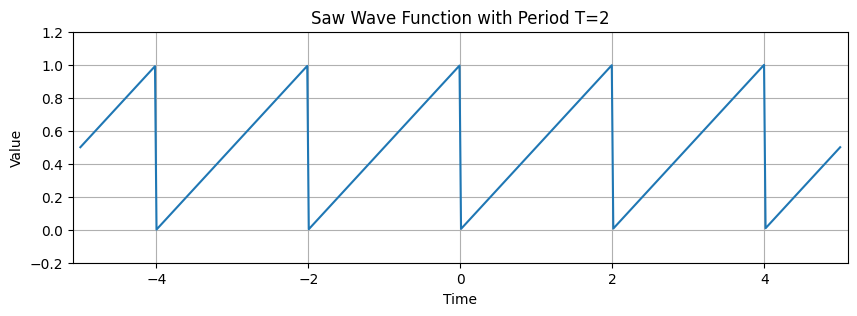

In [58]:
def saw_wave(t, T=2):
    return (t%T)/T

T = 2
nmax = 50 
t = np.linspace(-5, 5, 500)  # Time range from 0 to 10 with 500 points

y = saw_wave(t)
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)
plt.plot(t, y)
plt.title(f'Saw Wave Function with Period T={T}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-5.1, 5.1)  # Extend y-axis a bit for clearer visualization
plt.ylim(-0.2, 1.2)  # Extend y-axis a bit for clearer visualization
plt.grid()
plt.show()

---

Let me share the calculation flow for fourier transform of the saw function. After calculation, we can compute $c_n$ as:
$$
c_0 = \frac12 \\
c_n =  \frac{i}{2 n \pi} \hskip3em (n \neq 0) \\
$$

Let's implement $c_n$ based on this result and implement saw wave function only using sinusoidal waves.

---

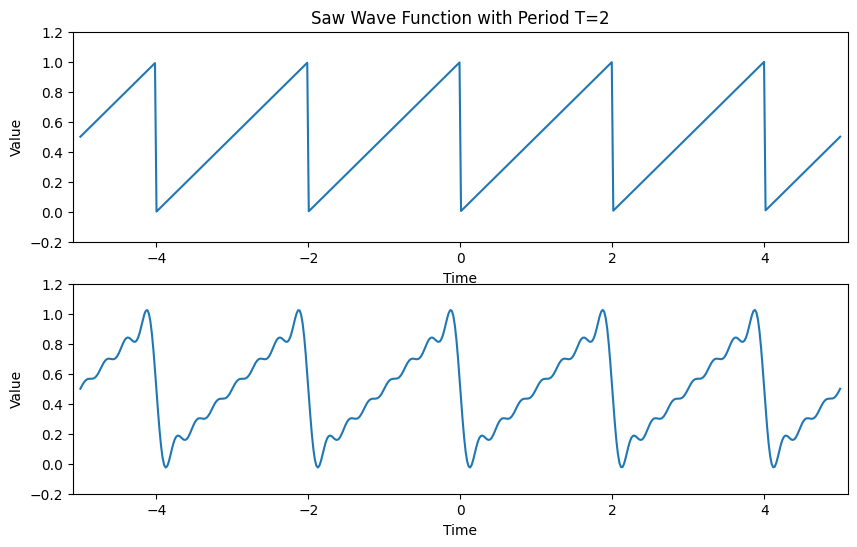

In [59]:
T = 2
nmax = 7 
t = np.linspace(-5, 5, 500)

y = saw_wave(t)
def c_saw(n):
    if n==0:
        cn = 1/2
    else:
        cn = 1j/(2*np.pi*n)
    return cn

def e_wave(n, t):
    return np.exp(1j*2*np.pi*n*t/T)

pred = c_saw(0)*e_wave(0, t)
for n in range(1, nmax+1):
    cn = c_saw(n)
    pred += cn * e_wave(n, t) + np.conj(cn) * e_wave(-n, t)
pred = pred.real

fig = plt.figure(figsize=(10, 6))
for i, data in enumerate([y, pred]):
    ax = fig.add_subplot(2, 1, i+1)
    plt.plot(t, data)
    if i==0:
        plt.title(f'Saw Wave Function with Period T={T}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xlim(-5.1, 5.1)  
    plt.ylim(-0.2, 1.2)  
plt.show()